# Stitching and Normalisation

In this notebook we look at how to stitch CMIP6 output files together to create continuous timeseries and how to determine how to normalise these files e.g. calculate anomalies against piControl runs.

In [1]:
# NBVAL_IGNORE_OUTPUT
import datetime as dt
import os.path
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pyam
import pymagicc
from netcdf_scm.io import load_scmdataframe
from scmdata import df_append

<IPython.core.display.Javascript object>

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192


In [2]:
plt.style.use('bmh') 
%matplotlib inline

## Command line interface help

The help can be accessed via our command line interface.

In [3]:
# NBVAL_IGNORE_OUTPUT
!netcdf-scm-stitch -h

Usage: netcdf-scm-stitch [OPTIONS] SRC DST STITCH_CONTACT

  Stitch NetCDF-SCM ``.nc`` files together and write out in the specified
  format.

  ``SRC`` is searched recursively and netcdf-scm will attempt to stitch all
  the files found. Output is written in ``DST``.

  ``STITCH_CONTACT`` is written into the header of the output files.

Options:
  --regexp TEXT                   Regular expression to apply to file
                                  directory (only stitches matches).
                                  [default: ^(?!.*(fx)).*$]
  --prefix TEXT                   Prefix to apply to output file names (not
                                  paths).
  --out-format [mag-files|mag-files-average-year-start-year|mag-files-average-year-mid-year|mag-files-average-year-end-year|mag-files-point-start-year|mag-files-point-mid-year|mag-files-point-end-year|magicc-input-files|magicc-input-files-average-year-start-year|magicc-input-files-average-year-mid-year|magicc-input-files-average-yea

## Stitching

Stitching simply refers to joining a child scenario with its parent. For example, an ssp with its corresponding historical run.

In [4]:
# NBVAL_IGNORE_OUTPUT
!netcdf-scm-stitch "../tests/test-data/expected-crunching-output/cmip6output/CMIP6" "../output-examples/stitched-files" "notebook example <email address>" --force --drs "CMIP6Output" --regexp ".*EC-Earth3-Veg.*ssp585.*r1i1p1f1.*hfds.*"

2019-11-08 11:36:03,351 INFO:netcdf_scm:netcdf-scm: 2.0.0-beta.1+12.ge0d22ff
2019-11-08 11:36:03,351 INFO:netcdf_scm:stitch-contact: notebook example <email address>
2019-11-08 11:36:03,351 INFO:netcdf_scm:source: /Users/znicholls/Documents/AGCEC/Misc/netcdf-scm/tests/test-data/expected-crunching-output/cmip6output/CMIP6
2019-11-08 11:36:03,351 INFO:netcdf_scm:destination: /Users/znicholls/Documents/AGCEC/Misc/netcdf-scm/output-examples/stitched-files
2019-11-08 11:36:03,351 INFO:netcdf_scm:regexp: .*EC-Earth3-Veg.*ssp585.*r1i1p1f1.*hfds.*
2019-11-08 11:36:03,351 INFO:netcdf_scm:prefix: None
2019-11-08 11:36:03,352 INFO:netcdf_scm:out-format: mag-files
2019-11-08 11:36:03,352 INFO:netcdf_scm:drs: CMIP6Output
2019-11-08 11:36:03,352 INFO:netcdf_scm:force: True
2019-11-08 11:36:03,352 INFO:netcdf_scm:number-workers: 4
2019-11-08 11:36:03,352 INFO:netcdf_scm:target-units-specs: None
2019-11-08 11:36:03,352 INFO:netcdf_scm:normalise: None
2019-11-08 11:36:03,352 INFO:netcdf_scm:Finding dir

We can then load the resulting files using Pymagicc.

In [5]:
written_files = [f for f in Path("../output-examples/stitched-files/flat").rglob("*.MAG")]
written_files

[PosixPath('../output-examples/stitched-files/flat/netcdf-scm_hfds_Omon_EC-Earth3-Veg_ssp585_r1i1p1f1_gn_201501-201712.MAG')]

As we can see below, the output file is the result of joining the scenario and historical file (i.e. we have data pre-2015, which is when the scenario started).

In [6]:
stitched = pymagicc.io.MAGICCData(str(written_files[0]))
stitched.timeseries()

time                                                                                           2012-01-15 12:00:00  \
model       scenario    region                          variable unit      climate_model todo                        
unspecified unspecified World                           hfds     Wmsuper-2 unspecified   SET               6.09994   
                        World|El Nino N3.4              hfds     Wmsuper-2 unspecified   SET              42.06670   
                        World|North Atlantic Ocean      hfds     Wmsuper-2 unspecified   SET            -131.94000   
                        World|Northern Hemisphere       hfds     Wmsuper-2 unspecified   SET            -104.36000   
                        World|Northern Hemisphere|Ocean hfds     Wmsuper-2 unspecified   SET            -104.36000   
                        World|Ocean                     hfds     Wmsuper-2 unspecified   SET               6.09994   
                        World|Southern Hemisphere       hfds     Wmsuper-2 unspecified   SET              93.36680   
                        World|Southern Hemisphere|Ocean hfds     Wmsuper-2 unspecified   SET              93.36680   

time                                                                                           2012-02-14 12:00:00  \
model       scenario    region                          variable unit      climate_model todo                        
unspecified unspecified World                           hfds     Wmsuper-2 unspecified   SET               2.72503   
                        World|El Nino N3.4              hfds     Wmsuper-2 unspecified   SET              60.51390   
                        World|North Atlantic Ocean      hfds     Wmsuper-2 unspecified   SET             -72.55420   
                        World|Northern Hemisphere       hfds     Wmsuper-2 unspecified   SET             -71.78500   
                        World|Northern Hemisphere|Ocean hfds     Wmsuper-2 unspecified   SET             -71.78500   
                        World|Ocean                     hfds     Wmsuper-2 unspecified   SET               2.72503   
                        World|Southern Hemisphere       hfds     Wmsuper-2 unspecified   SET              61.59030   
                        World|Southern Hemisphere|Ocean hfds     Wmsuper-2 unspecified   SET              61.59030   

time                                                                                           2012-03-15 12:00:00  \
model       scenario    region                          variable unit      climate_model todo                        
unspecified unspecified World                           hfds     Wmsuper-2 unspecified   SET             -0.248865   
                        World|El Nino N3.4              hfds     Wmsuper-2 unspecified   SET             64.278200   
                        World|North Atlantic Ocean      hfds     Wmsuper-2 unspecified   SET            -26.789700   
                        World|Northern Hemisphere       hfds     Wmsuper-2 unspecified   SET            -16.934200   
                        World|Northern Hemisphere|Ocean hfds     Wmsuper-2 unspecified   SET            -16.934200   
                        World|Ocean                     hfds     Wmsuper-2 unspecified   SET             -0.248865   
                        World|Southern Hemisphere       hfds     Wmsuper-2 unspecified   SET             12.933100   
                        World|Southern Hemisphere|Ocean hfds     Wmsuper-2 unspecified   SET             12.933100   

time                                                                                           2012-04-15 00:00:00  \
model       scenario    region                          variable unit      climate_model todo                        
unspecified unspecified World                           hfds     Wmsuper-2 unspecified   SET              -9.44095   
                        World|El Nino N3.4              hfds     Wmsuper-2 unspecified   SET           

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


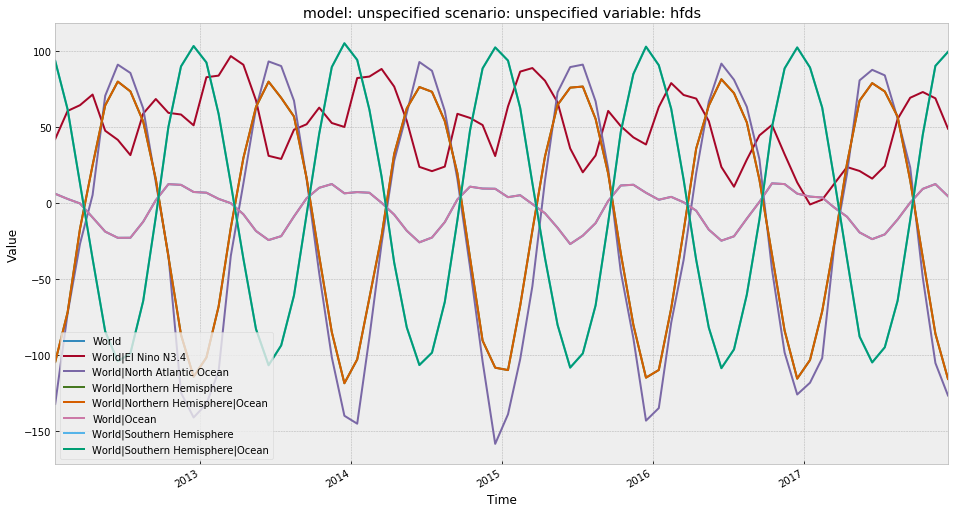

In [7]:
# NBVAL_IGNORE_OUTPUT
stitched.line_plot(color="region", figsize=(16, 9))

The files are also written with extensive metadata, which we can access via the `MAGICCData` instance's `.metadata` attribute. The 'child' metadata is the metadata of the 'child' simulation (in this case 'ssp585') while the parent data is the data from the simulation the 'child' branched off (in this case 'historical').

In [8]:
# NBVAL_IGNORE_OUTPUT
stitched.metadata

{'timeseriestype': 'MONTHLY',
 'date': '2019-11-08 11:36:06',
 'contact': 'notebook example <email address>',
 '(child) CDI': 'Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/cdi)',
 '(child) CDO': 'Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/cdo)',
 '(child) Conventions': 'CF-1.5',
 '(child) area_world (m**2)': '4592406696896.0',
 '(child) area_world_el_nino_n3.4 (m**2)': '59942346240.0',
 '(child) area_world_north_atlantic_ocean (m**2)': '499489548032.0',
 '(child) area_world_northern_hemisphere (m**2)': '2026861311360.0',
 '(child) area_world_northern_hemisphere_ocean (m**2)': '2026861311360.0',
 '(child) area_world_ocean (m**2)': '4592406696896.0',
 '(child) area_world_southern_hemisphere (m**2)': '2565545385536.0',
 '(child) area_world_southern_hemisphere_ocean (m**2)': '2565545385536.0',
 '(child) branch_method': 'standard',
 '(child) branch_time_in_child': '60265.0',
 '(child) branch_time_in_parent': '60265.0',
 '(child) calendar': 'proleptic_gregorian'

## Stitching and normalising

On top of stitching, we might also normalise. This means we find the piControl run, and then normalise our output data against the piControl somehow. At the moment, the only method we have implemented is normalising against a mean of the 31 years after the branch time (31 years so that if the branch time is 1960, we take data from 1960 up to and including 1991) in the piControl, but we can add more if required.

In [9]:
# NBVAL_IGNORE_OUTPUT
!netcdf-scm-stitch "../tests/test-data/expected-crunching-output/cmip6output/CMIP6" "../output-examples/stitched-normalised-files" "notebook example <email address>" --force --drs "CMIP6Output" --regexp ".*BCC-CSM2-MR.*ssp126.*tas.*" --normalise "31-yr-mean-after-branch-time"

2019-11-08 11:36:10,512 INFO:netcdf_scm:netcdf-scm: 2.0.0-beta.1+12.ge0d22ff
2019-11-08 11:36:10,512 INFO:netcdf_scm:stitch-contact: notebook example <email address>
2019-11-08 11:36:10,512 INFO:netcdf_scm:source: /Users/znicholls/Documents/AGCEC/Misc/netcdf-scm/tests/test-data/expected-crunching-output/cmip6output/CMIP6
2019-11-08 11:36:10,512 INFO:netcdf_scm:destination: /Users/znicholls/Documents/AGCEC/Misc/netcdf-scm/output-examples/stitched-normalised-files
2019-11-08 11:36:10,512 INFO:netcdf_scm:regexp: .*BCC-CSM2-MR.*ssp126.*tas.*
2019-11-08 11:36:10,512 INFO:netcdf_scm:prefix: None
2019-11-08 11:36:10,512 INFO:netcdf_scm:out-format: mag-files
2019-11-08 11:36:10,512 INFO:netcdf_scm:drs: CMIP6Output
2019-11-08 11:36:10,513 INFO:netcdf_scm:force: True
2019-11-08 11:36:10,513 INFO:netcdf_scm:number-workers: 4
2019-11-08 11:36:10,513 INFO:netcdf_scm:target-units-specs: None
2019-11-08 11:36:10,513 INFO:netcdf_scm:normalise: 31-yr-mean-after-branch-time
2019-11-08 11:36:10,513 INFO:

In [10]:
written_files = [f for f in Path("../output-examples/stitched-normalised-files/flat").rglob("*.MAG")]
written_files

[PosixPath('../output-examples/stitched-normalised-files/flat/netcdf-scm_tas_Amon_BCC-CSM2-MR_ssp126_r1i1p1f1_gn_201501-210012.MAG')]

In [11]:
stitched_normalised = pymagicc.io.MAGICCData(str(written_files[0]))
stitched_normalised.timeseries()

time                                                                                      1850-01-15 12:00:00  \
model       scenario    region                          variable unit climate_model todo                        
unspecified unspecified World                           tas      K    unspecified   SET              -2.08592   
                        World|El Nino N3.4              tas      K    unspecified   SET               1.06368   
                        World|Land                      tas      K    unspecified   SET              -6.49922   
                        World|North Atlantic Ocean      tas      K    unspecified   SET              -1.68370   
                        World|Northern Hemisphere       tas      K    unspecified   SET              -6.71904   
                        World|Northern Hemisphere|Land  tas      K    unspecified   SET             -12.48810   
                        World|Northern Hemisphere|Ocean tas      K    unspecified   SET              -3.02400   
                        World|Ocean                     tas      K    unspecified   SET              -0.28553   
                        World|Southern Hemisphere       tas      K    unspecified   SET               2.54719   
                        World|Southern Hemisphere|Land  tas      K    unspecified   SET               5.86804   
                        World|Southern Hemisphere|Ocean tas      K    unspecified   SET               1.77295   

time                                                                                      1850-02-14 00:00:00  \
model       scenario    region                          variable unit climate_model todo                        
unspecified unspecified World                           tas      K    unspecified   SET             -1.851060   
                        World|El Nino N3.4              tas      K    unspecified   SET              1.114390   
                        World|Land                      tas      K    unspecified   SET             -6.259700   
                        World|North Atlantic Ocean      tas      K    unspecified   SET             -2.103410   
                        World|Northern Hemisphere       tas      K    unspecified   SET             -6.332030   
                        World|Northern Hemisphere|Land  tas      K    unspecified   SET            -11.188000   
                        World|Northern Hemisphere|Ocean tas      K    unspecified   SET             -3.221840   
                        World|Ocean                     tas      K    unspecified   SET             -0.052571   
                        World|Southern Hemisphere       tas      K    unspecified   SET              2.629900   
                        World|Southern Hemisphere|Land  tas      K    unspecified   SET              3.917360   
                        World|Southern Hemisphere|Ocean tas      K    unspecified   SET              2.329740   

time                                                                                      1850-03-15 12:00:00  \
model       scenario    region                          variable unit climate_model todo                        
unspecified unspecified World                           tas      K    unspecified   SET             -1.396900   
                        World|El Nino N3.4              tas      K    unspecified   SET              0.732798   
                        World|Land                      tas      K    unspecified   SET             -4.732470   
                        World|North Atlantic Ocean      tas      K    unspecified   SET             -1.924300   
                        World|Northern Hemisphere       tas      K    unspecified   SET             -4.811410   
                        World|Northern Hemisphere|Land  tas      K    unspecified   SET             -7.714480   
                        World|Northern Hemisphere|Ocean tas      K    unspecified   SET             -2.952010   
                        World|Ocean        

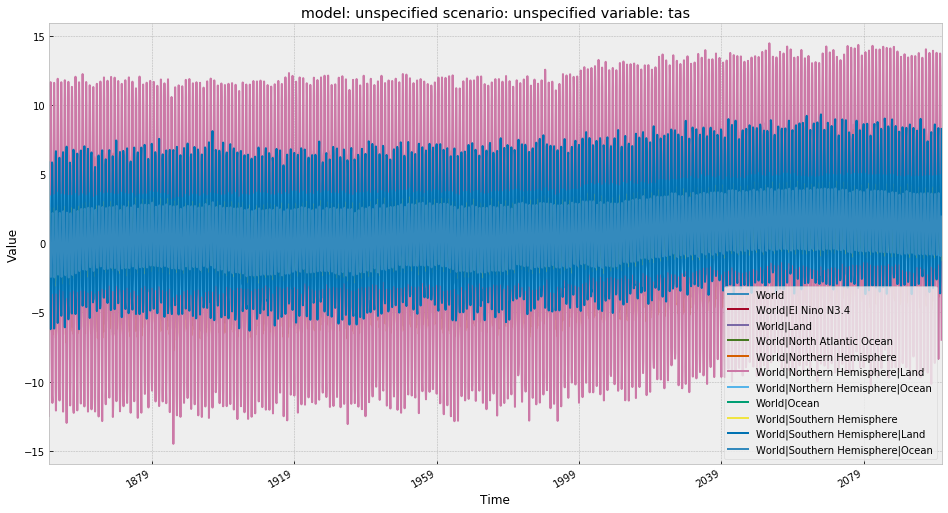

In [12]:
stitched_normalised.line_plot(color="region", figsize=(16, 9));

As we have monthly data, this doesn't tell us much yet. We can take an annual mean before plotting to see a clearer picture.

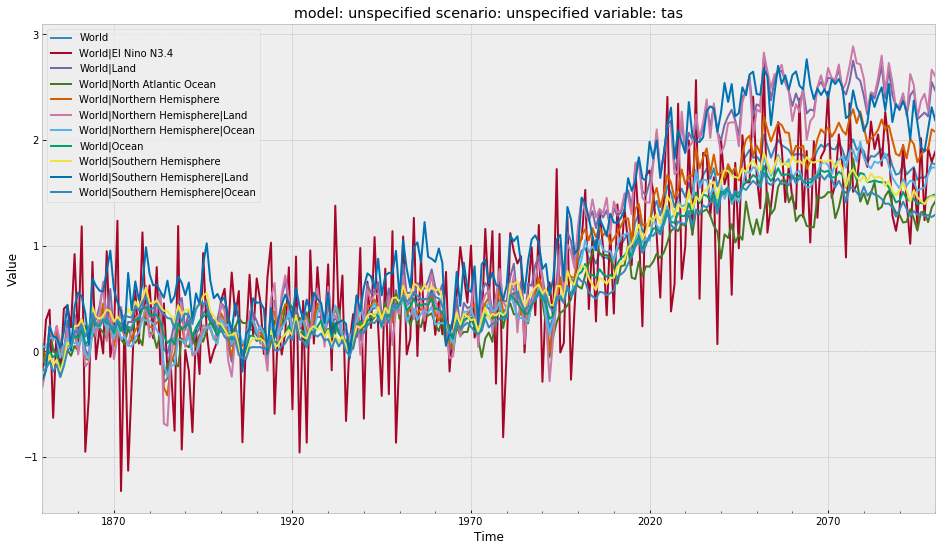

In [13]:
stitched_normalised.time_mean("AC").line_plot(color="region", figsize=(16, 9));

With a bit of digging, we can get see all the data used to make the above plot.

In [14]:
test_cmip6_crunch_output = os.path.join(
    "..", "tests", "test-data", "expected-crunching-output", "cmip6output"
)

In [15]:
# NBVAL_IGNORE_OUTPU
def load_src(src):
    return load_scmdataframe(
        os.path.join(
            test_cmip6_crunch_output, 
            stitched_normalised.metadata["({}) netcdf-scm crunched file".format(src)],
        )
    )

child = load_src("child")
parent = load_src("parent")
normalisation = load_src("normalisation")

normalisation.head()

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


time                                                                                                                                   1850-01-16 12:00:00  \
model       scenario  region                         variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl World|North Atlantic Ocean     tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  291.246503   
                      World|Southern Hemisphere|Land tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  284.406353   
                      World|Land                     tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  274.787241   
                      World                          tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  285.487919   
                      World|Southern Hemisphere      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  290.024244   

time                                                                                                                                   1850-02-15 00:00:00  \
model       scenario  region                         variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl World|North Atlantic Ocean     tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  290.780598   
                      World|Southern Hemisphere|Land tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  282.242578   
                      World|Land                     tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  275.162052   
                      World                          tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  285.769434   
                      World|Southern Hemisphere      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  290.045685   

time                                                                                                                                   1850-03-16 12:00:00  \
model       scenario  region                         variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl World|North Atlantic Ocean     tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  290.691142   
                      World|Southern Hemisphere|Land tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  279.549532   
                      World|Land                     tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  276.320696   
                      World                          tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  286.174939   
                      World|Southern Hemisphere      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  289.392241   

time                                                                                                                                   1850-04-16 00:00:00  \
model       scenario  region                         variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl World|North Atlantic Ocean     tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  291.169737   
                      World|Southern Hemisphere|Land tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  277.604311   
                      World|Land               

We can use the metadata to recover the branching time. For the BCC model, the metadata appears to be wrong as the `branch_time_in_parent` attribute looks to be in years, rather than days as is expected (given the units provided).

In [16]:
parent.metadata["branch_time_in_parent"]

2289.0

In [17]:
parent.metadata["parent_time_units"]

'days since 1850-01-01'

Anyway, we can nonetheless determine the branch time. Due to the conflicting information above, here we simply assert things are expected and move on.

In [18]:
assert parent.metadata["branch_time_in_parent"] == 2289.0
assert parent.metadata["parent_time_units"] == "days since 1850-01-01"
branch_year = 2289

We can then shift our normalisation such that the branch times line up.

In [19]:
normalisation_shifted = normalisation.timeseries()
normalisation_shifted.columns = normalisation_shifted.columns.map(
    lambda x: dt.datetime(x.year - branch_year + parent["time"].min().year, x.month, x.day, x.hour)
)
normalisation_shifted = normalisation_shifted.reset_index()
normalisation_shifted["scenario"] = "piControl-shifted"
normalisation_shifted = df_append([normalisation_shifted])
normalisation_shifted.head()

time                                                                                                                                       1411-01-16 12:00:00  \
model       scenario          region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl-shifted World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  285.487919   
                              World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  299.072634   
                              World|Land                 tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  274.787241   
                              World|North Atlantic Ocean tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  291.246503   
                              World|Northern Hemisphere  tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  280.951595   

time                                                                                                                                       1411-02-15 00:00:00  \
model       scenario          region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl-shifted World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  285.769434   
                              World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  299.465637   
                              World|Land                 tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  275.162052   
                              World|North Atlantic Ocean tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  290.780598   
                              World|Northern Hemisphere  tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  281.493183   

time                                                                                                                                       1411-03-16 12:00:00  \
model       scenario          region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl-shifted World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  286.174939   
                              World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  299.799973   
                              World|Land                 tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  276.320696   
                              World|North Atlantic Ocean tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  290.691142   
                              World|Northern Hemisphere  tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  282.957637   

time                                                                                                                                       1411-04-16 00:00:00  \
model       scenario          region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified piControl-shifted World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                  287.622444   
                              World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CM

In [20]:
source_data = df_append([
    child, parent, normalisation, normalisation_shifted
])
source_data.head()

time                                                                                                                                1411-01-16 12:00:00  \
model       scenario   region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified historical World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|Land                 tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|North Atlantic Ocean tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|Northern Hemisphere  tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   

time                                                                                                                                1411-02-15 00:00:00  \
model       scenario   region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified historical World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|Land                 tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|North Atlantic Ocean tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|Northern Hemisphere  tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   

time                                                                                                                                1411-03-16 12:00:00  \
model       scenario   region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified historical World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|Land                 tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|North Atlantic Ocean tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|Northern Hemisphere  tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   

time                                                                                                                                1411-04-16 00:00:00  \
model       scenario   region                     variable unit activity_id climate_model member_id mip_era variable_standard_name                        
unspecified historical World                      tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|El Nino N3.4         tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperature                         NaN   
                       World|Land                 tas      K    CMIP        BCC-CSM2-MR   r1i1p1f1  CMIP6   air_temperatur

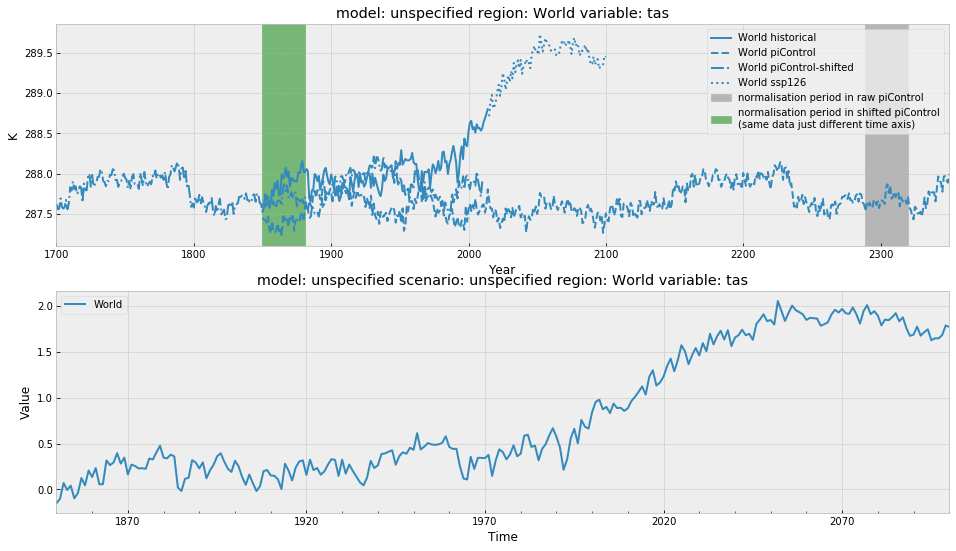

In [21]:
# plotting not playing nice so have to hack around...
region_to_plot = "World"
years_to_plot = range(1700, 2351)
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(211)
plt_here = source_data.time_mean("AC").timeseries()
plt_here.columns = plt_here.columns.map(lambda x: x.year)
plt_here = pyam.IamDataFrame(plt_here)
plt_here.filter(
    region=region_to_plot, year=years_to_plot
).line_plot(color="region", linestyle="scenario", ax=ax)
ax.axvspan(
    branch_year, branch_year + 31, 
    label="normalisation period in raw piControl", 
    alpha=0.5, color="gray"
)
ax.axvspan(
    parent["time"].min().year, parent["time"].min().year + 31, 
    label="normalisation period in shifted piControl\n(same data just different time axis)", 
    alpha=0.5, color="green"
)
ax.legend()

ax = fig.add_subplot(212)
stitched_normalised.filter(
    region=region_to_plot, year=years_to_plot
).time_mean("AC").line_plot(color="region", ax=ax);

In the top panel above, we can see how the historical and ssp126 simulations have been joined. We can also see the normalisation period that is used. In the bottom panel, we can see the resulting stitched and normalised timeseries.